#**Import**

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import GradScaler, autocast


#**Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir="/content/drive/My Drive/APS360data/train"
val_dir="/content/drive/My Drive/APS360data/val"


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

torch.manual_seed(1)
# Define transformations and normalization for your images:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for the resnet model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for ImageNet
])

# Load datasets:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)


# Set up data loaders:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  #Shuffle is to ensure the model isn’t adapting its learning to any kind of spurious pattern.
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


#**Model**

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, in_channels, resblock, num_classes = 4):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(512, 4)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        input = torch.flatten(input, start_dim=1)
        input = self.fc(input)

        return input


In [ ]:
resnet18 = ResNet18(3, ResBlock, num_classes = 4)

#**Train the model**

In [ ]:
def train(model, train_loader, validation_loader, num_epochs, optimizer, scheduler=None):
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Initialize the gradient scaler for mixed precision
    scaler = GradScaler()
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        total_train, correct_train, running_loss = 0, 0, 0.0
        train_preds, train_targets = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            running_loss += loss.item() * inputs.size(0)
            train_preds.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        train_f1 = f1_score(train_targets, train_preds, average='weighted')

        if scheduler:
            scheduler.step()  # Adjust the learning rate after each epoch

        # Validation Phase
        model.eval()
        val_running_loss, total_val, correct_val = 0.0, 0, 0
        val_preds, val_targets = [], []
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(validation_loader.dataset)
        val_accuracy = 100 * correct_val / total_val
        val_f1 = f1_score(val_targets, val_preds, average='weighted')


        #store the result of accuracy, loss
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        # Print both training and validation metrics
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}%, F1-Score: {train_f1:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}%, F1-Score: {val_f1:.4f}\n')

    #Making the plot
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

In [ ]:
train(resnet18,train_loader, validation_loader,
          batch_size = 32, lr = 0.001, num_epochs = 15)

Epoch 1/15
Training Accuracy: 0.0000, F1-Score: 0.0000, Loss: 10.6197
Validation Accuracy: 0.0000, F1-Score: 0.0000, Loss: 10.7045, 
Epoch 2/15
Training Accuracy: 0.0000, F1-Score: 0.0000, Loss: 10.6188
Validation Accuracy: 0.0000, F1-Score: 0.0000, Loss: 10.5624, 


KeyboardInterrupt: 

In [ ]:
resnet18 = ResNet18(3, ResBlock, num_classes = 4)

train(resnet18,train_loader, validation_loader,
          batch_size = 32, lr = 0.001, num_epochs = 15)

Epoch 1/15
Training Accuracy: 0.5967, F1-Score: 0.5908, Loss: 1.1355
Validation Accuracy: 0.4500, F1-Score: 0.4049, Loss: 3.0094, 
Epoch 2/15
Training Accuracy: 0.7117, F1-Score: 0.7061, Loss: 0.7665
Validation Accuracy: 0.6650, F1-Score: 0.6418, Loss: 1.1455, 
Epoch 3/15
Training Accuracy: 0.7183, F1-Score: 0.7193, Loss: 0.7383
Validation Accuracy: 0.5800, F1-Score: 0.5843, Loss: 0.9426, 
Epoch 4/15
Training Accuracy: 0.7533, F1-Score: 0.7511, Loss: 0.6609
Validation Accuracy: 0.6300, F1-Score: 0.6213, Loss: 1.1974, 
Epoch 5/15
Training Accuracy: 0.7267, F1-Score: 0.7266, Loss: 0.7163
Validation Accuracy: 0.5250, F1-Score: 0.4801, Loss: 1.1167, 


KeyboardInterrupt: 

#**optimizer**

In [ ]:
resnet18 = resnet18 = models.resnet.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 34.6MB/s]


In [ ]:
# For multi-class classification
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)  # default learning rate

#device should be defined based on system's configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#Tuning 1: Learning Rate

/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/15
Training Loss: 1.1601, Accuracy: 56.8333%, F1-Score: 0.5671
Validation Loss: 4.0889, Accuracy: 45.5000%, F1-Score: 0.4318



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 2/15
Training Loss: 0.7488, Accuracy: 70.6667%, F1-Score: 0.6967
Validation Loss: 1.3459, Accuracy: 55.5000%, F1-Score: 0.5497



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 3/15
Training Loss: 0.7034, Accuracy: 75.0000%, F1-Score: 0.7507
Validation Loss: 0.8004, Accuracy: 71.5000%, F1-Score: 0.7039



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 4/15
Training Loss: 0.7715, Accuracy: 71.0000%, F1-Score: 0.7059
Validation Loss: 0.9027, Accuracy: 68.5000%, F1-Score: 0.6702



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 5/15
Training Loss: 0.6975, Accuracy: 75.1667%, F1-Score: 0.7510
Validation Loss: 1.0885, Accuracy: 66.0000%, F1-Score: 0.6430



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 6/15
Training Loss: 0.6752, Accuracy: 76.3333%, F1-Score: 0.7629
Validation Loss: 0.9074, Accuracy: 65.0000%, F1-Score: 0.6377



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 7/15
Training Loss: 0.6574, Accuracy: 76.8333%, F1-Score: 0.7669
Validation Loss: 0.8842, Accuracy: 66.0000%, F1-Score: 0.6487



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 8/15
Training Loss: 0.6745, Accuracy: 77.3333%, F1-Score: 0.7729
Validation Loss: 0.8732, Accuracy: 65.5000%, F1-Score: 0.6425



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 9/15
Training Loss: 0.6607, Accuracy: 77.6667%, F1-Score: 0.7767
Validation Loss: 0.8879, Accuracy: 65.5000%, F1-Score: 0.6425



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 10/15
Training Loss: 0.6705, Accuracy: 77.0000%, F1-Score: 0.7694
Validation Loss: 0.8809, Accuracy: 66.0000%, F1-Score: 0.6485



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 11/15
Training Loss: 0.6608, Accuracy: 77.0000%, F1-Score: 0.7676
Validation Loss: 0.8748, Accuracy: 66.5000%, F1-Score: 0.6545



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 12/15
Training Loss: 0.6894, Accuracy: 77.5000%, F1-Score: 0.7728
Validation Loss: 0.8811, Accuracy: 66.0000%, F1-Score: 0.6486



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 13/15
Training Loss: 0.6834, Accuracy: 78.3333%, F1-Score: 0.7823
Validation Loss: 0.8888, Accuracy: 65.5000%, F1-Score: 0.6425



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 14/15
Training Loss: 0.6867, Accuracy: 75.5000%, F1-Score: 0.7534
Validation Loss: 0.8694, Accuracy: 66.5000%, F1-Score: 0.6544



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 15/15
Training Loss: 0.6682, Accuracy: 76.0000%, F1-Score: 0.7602
Validation Loss: 0.8792, Accuracy: 66.5000%, F1-Score: 0.6544



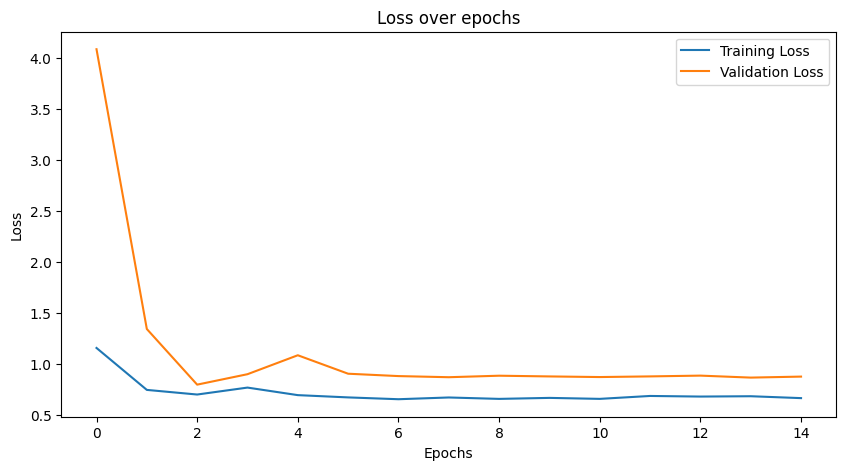

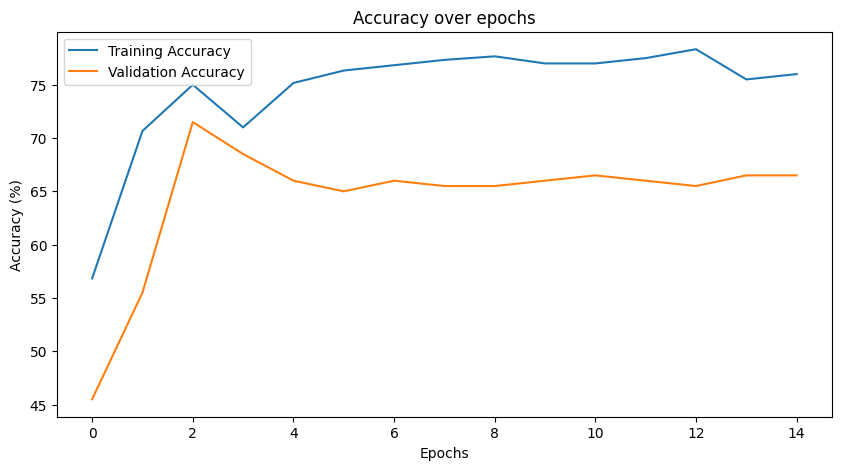

In [ ]:
scheduler = StepLR(optimizer, step_size=5, gamma=0.0001)
train(resnet18, train_loader, validation_loader, num_epochs=15, optimizer=optimizer, scheduler=scheduler)

#**Tuning 2: Learning Rate**

/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/20
Training Loss: 1.2145, Accuracy: 58.6667%, F1-Score: 0.5838
Validation Loss: 4.2576, Accuracy: 57.5000%, F1-Score: 0.5276



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 2/20
Training Loss: 0.8038, Accuracy: 66.5000%, F1-Score: 0.6625
Validation Loss: 0.9269, Accuracy: 71.0000%, F1-Score: 0.6872



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 3/20
Training Loss: 0.7467, Accuracy: 71.3333%, F1-Score: 0.7033
Validation Loss: 1.4455, Accuracy: 69.5000%, F1-Score: 0.6716



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 4/20
Training Loss: 0.7490, Accuracy: 69.3333%, F1-Score: 0.6901
Validation Loss: 0.9725, Accuracy: 73.0000%, F1-Score: 0.6994



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 5/20
Training Loss: 0.6599, Accuracy: 75.8333%, F1-Score: 0.7563
Validation Loss: 1.1094, Accuracy: 64.0000%, F1-Score: 0.6371



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 6/20
Training Loss: 0.6555, Accuracy: 74.0000%, F1-Score: 0.7398
Validation Loss: 0.9359, Accuracy: 67.5000%, F1-Score: 0.6761



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 7/20
Training Loss: 0.7153, Accuracy: 74.3333%, F1-Score: 0.7415
Validation Loss: 0.9485, Accuracy: 64.0000%, F1-Score: 0.6132



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 8/20
Training Loss: 0.5822, Accuracy: 79.1667%, F1-Score: 0.7890
Validation Loss: 0.7751, Accuracy: 72.5000%, F1-Score: 0.7130



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 9/20
Training Loss: 0.6444, Accuracy: 75.8333%, F1-Score: 0.7560
Validation Loss: 1.0569, Accuracy: 52.0000%, F1-Score: 0.5010



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 10/20
Training Loss: 0.6287, Accuracy: 77.6667%, F1-Score: 0.7768
Validation Loss: 0.7898, Accuracy: 72.0000%, F1-Score: 0.6978



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 11/20
Training Loss: 0.5525, Accuracy: 79.3333%, F1-Score: 0.7916
Validation Loss: 0.7545, Accuracy: 70.5000%, F1-Score: 0.6967



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 12/20
Training Loss: 0.5723, Accuracy: 79.1667%, F1-Score: 0.7891
Validation Loss: 0.7524, Accuracy: 69.5000%, F1-Score: 0.6882



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 13/20
Training Loss: 0.5578, Accuracy: 80.0000%, F1-Score: 0.7991
Validation Loss: 0.7532, Accuracy: 71.0000%, F1-Score: 0.7017



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 14/20
Training Loss: 0.5564, Accuracy: 79.6667%, F1-Score: 0.7941
Validation Loss: 0.7629, Accuracy: 70.0000%, F1-Score: 0.6909



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 15/20
Training Loss: 0.6016, Accuracy: 77.5000%, F1-Score: 0.7745
Validation Loss: 0.7690, Accuracy: 70.5000%, F1-Score: 0.6978



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 16/20
Training Loss: 0.5809, Accuracy: 79.5000%, F1-Score: 0.7919
Validation Loss: 0.7601, Accuracy: 70.0000%, F1-Score: 0.6924



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 17/20
Training Loss: 0.6197, Accuracy: 75.6667%, F1-Score: 0.7557
Validation Loss: 0.7543, Accuracy: 70.0000%, F1-Score: 0.6907



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 18/20
Training Loss: 0.5586, Accuracy: 78.5000%, F1-Score: 0.7823
Validation Loss: 0.7667, Accuracy: 70.0000%, F1-Score: 0.6939



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 19/20
Training Loss: 0.5722, Accuracy: 80.3333%, F1-Score: 0.8027
Validation Loss: 0.7627, Accuracy: 69.5000%, F1-Score: 0.6849



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 20/20
Training Loss: 0.5785, Accuracy: 78.0000%, F1-Score: 0.7783
Validation Loss: 0.7628, Accuracy: 69.5000%, F1-Score: 0.6882



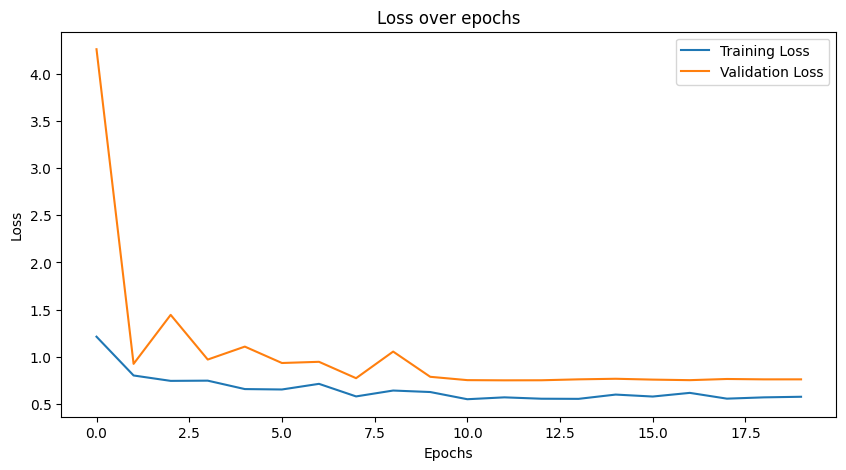

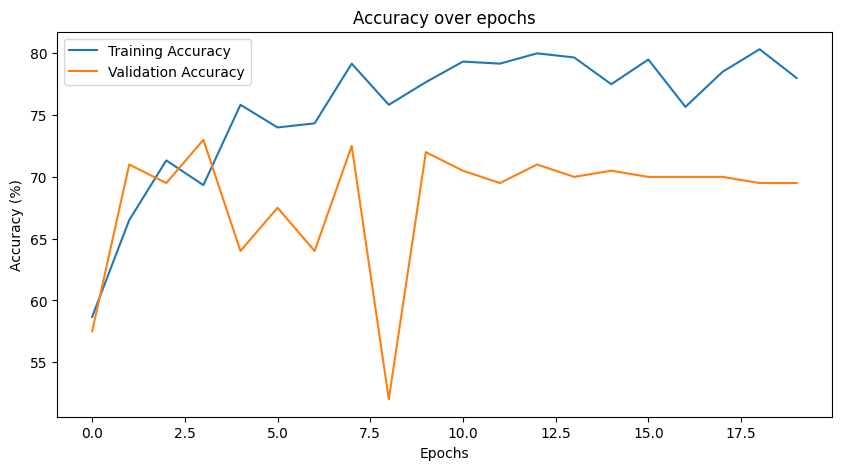

In [ ]:
scheduler = StepLR(optimizer, step_size=10, gamma=0.0001)
train(resnet18, train_loader, validation_loader, num_epochs=20, optimizer=optimizer, scheduler=scheduler)

#**Tuning 3: Batch Size**

In [ ]:
#Change the batchsize to see if it is helpful=  32--->45
torch.manual_seed(1)

#Data agumentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # resnet expects 224x224 inputs
    transforms.RandomHorizontalFlip(),  # Simple augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
])

# Load datasets:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
# Set up data loaders:
train_loader = DataLoader(train_dataset, batch_size=45, shuffle=True)  #Shuffle is to ensure the model isn’t adapting its learning to any kind of spurious pattern


# Define transformations and normalization for your images:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for the resnet model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for ImageNet
])

val_dataset = datasets.ImageFolder(val_dir, transform=transform)

# Set up data loaders:
validation_loader = DataLoader(val_dataset, batch_size=45, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/15
Training Loss: 1.2828, Accuracy: 57.1667%, F1-Score: 0.5757
Validation Loss: 24.9599, Accuracy: 44.5000%, F1-Score: 0.3349



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 2/15
Training Loss: 0.8872, Accuracy: 66.5000%, F1-Score: 0.6596
Validation Loss: 8.1961, Accuracy: 48.0000%, F1-Score: 0.4463



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 3/15
Training Loss: 0.8742, Accuracy: 66.1667%, F1-Score: 0.6534
Validation Loss: 0.9941, Accuracy: 55.0000%, F1-Score: 0.5151



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 4/15
Training Loss: 0.8571, Accuracy: 67.3333%, F1-Score: 0.6690
Validation Loss: 0.7647, Accuracy: 72.0000%, F1-Score: 0.6984



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 5/15
Training Loss: 0.7949, Accuracy: 70.8333%, F1-Score: 0.7011
Validation Loss: 0.7870, Accuracy: 69.0000%, F1-Score: 0.6925



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 6/15
Training Loss: 0.7437, Accuracy: 72.3333%, F1-Score: 0.7232
Validation Loss: 0.7782, Accuracy: 72.0000%, F1-Score: 0.7174



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 7/15
Training Loss: 0.7299, Accuracy: 75.1667%, F1-Score: 0.7527
Validation Loss: 0.7813, Accuracy: 72.5000%, F1-Score: 0.7207



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 8/15
Training Loss: 0.7812, Accuracy: 73.6667%, F1-Score: 0.7366
Validation Loss: 0.7895, Accuracy: 73.0000%, F1-Score: 0.7260



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 9/15
Training Loss: 0.7179, Accuracy: 73.1667%, F1-Score: 0.7300
Validation Loss: 0.7908, Accuracy: 72.5000%, F1-Score: 0.7221



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 10/15
Training Loss: 0.7374, Accuracy: 72.6667%, F1-Score: 0.7257
Validation Loss: 0.7895, Accuracy: 73.5000%, F1-Score: 0.7321



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 11/15
Training Loss: 0.7917, Accuracy: 72.5000%, F1-Score: 0.7252
Validation Loss: 0.7828, Accuracy: 73.0000%, F1-Score: 0.7260



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 12/15
Training Loss: 0.8006, Accuracy: 73.1667%, F1-Score: 0.7313
Validation Loss: 0.7864, Accuracy: 73.5000%, F1-Score: 0.7315



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 13/15
Training Loss: 0.8003, Accuracy: 72.1667%, F1-Score: 0.7216
Validation Loss: 0.7838, Accuracy: 73.5000%, F1-Score: 0.7291



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 14/15
Training Loss: 0.7311, Accuracy: 74.5000%, F1-Score: 0.7447
Validation Loss: 0.7854, Accuracy: 73.5000%, F1-Score: 0.7291



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 15/15
Training Loss: 0.8203, Accuracy: 71.6667%, F1-Score: 0.7160
Validation Loss: 0.7850, Accuracy: 73.0000%, F1-Score: 0.7248



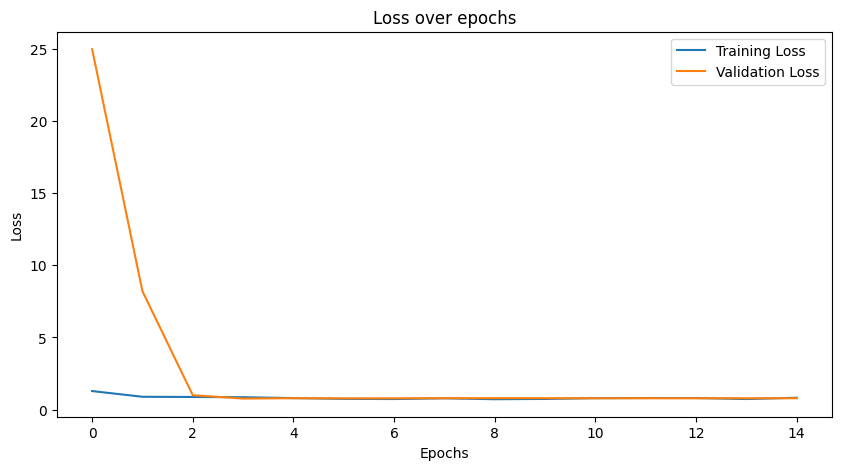

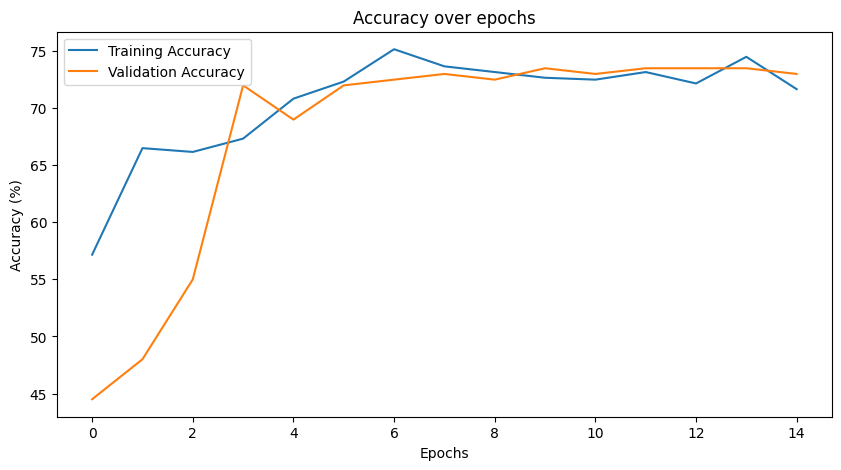

In [ ]:
scheduler = StepLR(optimizer, step_size=5, gamma=0.0001)
train(resnet18, train_loader, validation_loader, num_epochs=15, optimizer=optimizer, scheduler=scheduler)

#**Tuning 4: Batch Size**

In [ ]:
#Change the batchsize to see if it is helpful=  32--->60
torch.manual_seed(1)

#Data agumentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # VGG16 expects 224x224 inputs
    transforms.RandomHorizontalFlip(),  # Simple augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
])

# Load datasets:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
# Set up data loaders:
train_loader = DataLoader(train_dataset, batch_size=60, shuffle=True)  #Shuffle is to ensure the model isn’t adapting its learning to any kind of spurious pattern


# Define transformations and normalization for your images:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for the resnet model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for ImageNet
])

val_dataset = datasets.ImageFolder(val_dir, transform=transform)

# Set up data loaders:
validation_loader = DataLoader(val_dataset, batch_size=60, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/15
Training Loss: 1.4230, Accuracy: 28.3333%, F1-Score: 0.2029
Validation Loss: 1.3951, Accuracy: 32.0000%, F1-Score: 0.2515



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 2/15
Training Loss: 1.4143, Accuracy: 28.1667%, F1-Score: 0.2071
Validation Loss: 1.3958, Accuracy: 29.0000%, F1-Score: 0.2207



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 3/15
Training Loss: 1.4207, Accuracy: 26.0000%, F1-Score: 0.1888
Validation Loss: 1.3962, Accuracy: 29.5000%, F1-Score: 0.2244



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 4/15
Training Loss: 1.4234, Accuracy: 28.1667%, F1-Score: 0.2001
Validation Loss: 1.3951, Accuracy: 30.5000%, F1-Score: 0.2308



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 5/15
Training Loss: 1.4133, Accuracy: 29.8333%, F1-Score: 0.2172
Validation Loss: 1.3981, Accuracy: 30.0000%, F1-Score: 0.2326



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 6/15
Training Loss: 1.4191, Accuracy: 27.8333%, F1-Score: 0.1997
Validation Loss: 1.3947, Accuracy: 30.0000%, F1-Score: 0.2273



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 7/15
Training Loss: 1.4139, Accuracy: 27.8333%, F1-Score: 0.2124
Validation Loss: 1.3966, Accuracy: 29.5000%, F1-Score: 0.2244



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 8/15
Training Loss: 1.4178, Accuracy: 27.5000%, F1-Score: 0.2022
Validation Loss: 1.3968, Accuracy: 29.5000%, F1-Score: 0.2245



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 9/15
Training Loss: 1.4219, Accuracy: 26.8333%, F1-Score: 0.1896
Validation Loss: 1.3991, Accuracy: 30.0000%, F1-Score: 0.2275



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 10/15
Training Loss: 1.4220, Accuracy: 26.8333%, F1-Score: 0.1909
Validation Loss: 1.3945, Accuracy: 29.0000%, F1-Score: 0.2205



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 11/15
Training Loss: 1.4167, Accuracy: 26.6667%, F1-Score: 0.1952
Validation Loss: 1.3960, Accuracy: 30.5000%, F1-Score: 0.2309



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 12/15
Training Loss: 1.4180, Accuracy: 28.6667%, F1-Score: 0.2068
Validation Loss: 1.3963, Accuracy: 30.0000%, F1-Score: 0.2278



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 13/15
Training Loss: 1.4246, Accuracy: 29.1667%, F1-Score: 0.2102
Validation Loss: 1.3941, Accuracy: 30.5000%, F1-Score: 0.2309



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 14/15
Training Loss: 1.4166, Accuracy: 27.5000%, F1-Score: 0.1997
Validation Loss: 1.3961, Accuracy: 31.0000%, F1-Score: 0.2339



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 15/15
Training Loss: 1.4160, Accuracy: 27.3333%, F1-Score: 0.1960
Validation Loss: 1.3954, Accuracy: 30.0000%, F1-Score: 0.2273



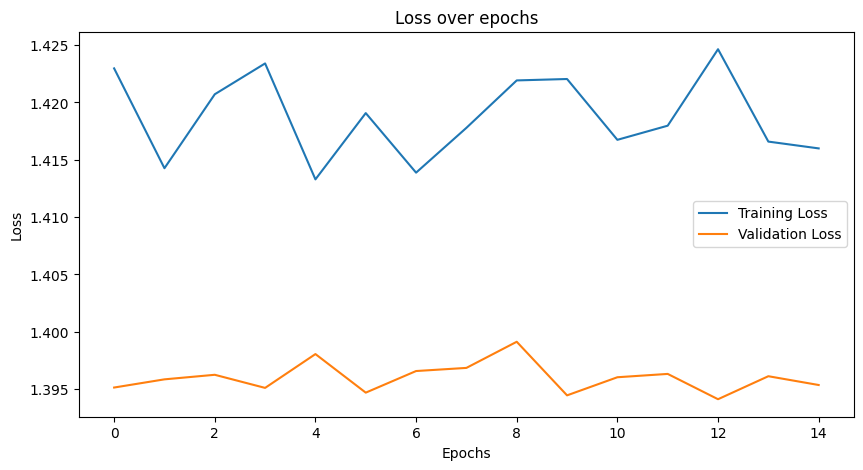

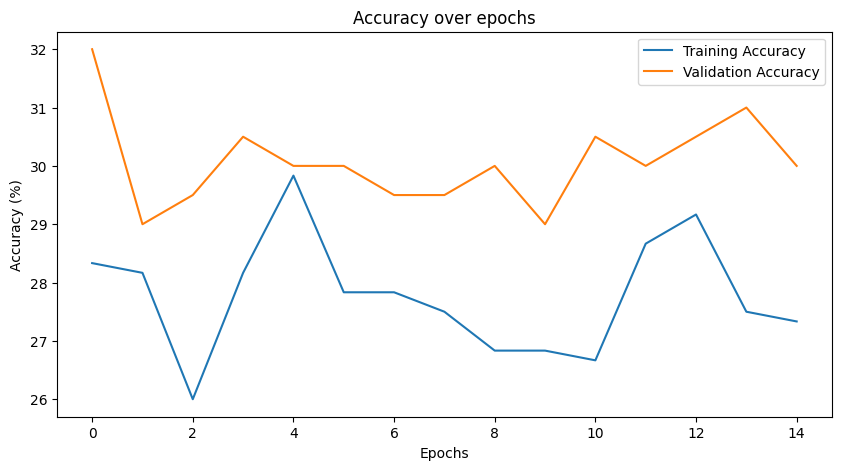

In [ ]:
scheduler = StepLR(optimizer, step_size=5, gamma=0.0001)
train(resnet18, train_loader, validation_loader, num_epochs=15, optimizer=optimizer, scheduler=scheduler)

In [ ]:
resnet18 = models.resnet.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 90.6MB/s]


In [ ]:
def train_net(model, train_loader, val_loader, batch_size=32,
              lr=0.001, num_epochs=15):
    criterion = nn.CrossEntropyLoss()
    # For multi-class classification
    optimizer = optim.Adam(resnet18.parameters(), lr=0.001)  # Use Adam optimizer with a learning rate of 0.01

    n = 0
    iters, losses, train_acc_list,val_acc_list = [],[],[],[]
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        train_preds = []
        train_targets = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu")), labels.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = accuracy_score(train_targets, train_preds)
        train_acc_list.append(epoch_acc)
        epoch_f1 = f1_score(train_targets, train_preds, average='weighted')


        model.eval()  # Set model to evaluate mode
        val_running_loss = 0.0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu")), labels.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = accuracy_score(val_targets, val_preds)
        val_acc_list.append(val_acc)
        val_f1 = f1_score(val_targets, val_preds, average='weighted')

        n += 1
        iters.append(n)
        losses.append(float(val_loss)/batch_size)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Training Accuracy: {epoch_acc:.4f}, F1-Score: {epoch_f1:.4f}, Loss: {epoch_loss:.4f}')
        print(f'Validation Accuracy: {val_acc:.4f}, F1-Score: {val_f1:.4f}, Loss: {val_loss:.4f}, ')
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy Curve")
    plt.plot(iters, train_acc_list, label="Training")
    plt.plot(iters, val_acc_list, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15
Training Accuracy: 0.7033, F1-Score: 0.7394, Loss: 2.0013
Validation Accuracy: 0.5800, F1-Score: 0.5327, Loss: 8.7752, 
Epoch 2/15
Training Accuracy: 0.8250, F1-Score: 0.8250, Loss: 0.6569
Validation Accuracy: 0.7550, F1-Score: 0.7524, Loss: 1.3549, 
Epoch 3/15
Training Accuracy: 0.8900, F1-Score: 0.8904, Loss: 0.3558
Validation Accuracy: 0.7250, F1-Score: 0.7333, Loss: 1.0991, 
Epoch 4/15
Training Accuracy: 0.9067, F1-Score: 0.9068, Loss: 0.2696
Validation Accuracy: 0.7900, F1-Score: 0.7820, Loss: 0.7781, 
Epoch 5/15
Training Accuracy: 0.9500, F1-Score: 0.9500, Loss: 0.1428
Validation Accuracy: 0.7400, F1-Score: 0.7369, Loss: 0.9906, 
Epoch 6/15
Training Accuracy: 0.9750, F1-Score: 0.9750, Loss: 0.0831
Validation Accuracy: 0.8600, F1-Score: 0.8608, Loss: 0.5340, 
Epoch 7/15
Training Accuracy: 0.9650, F1-Score: 0.9650, Loss: 0.1312
Validation Accuracy: 0.7900, F1-Score: 0.7845, Loss: 1.6866, 
Epoch 8/15
Training Accuracy: 0.9700, F1-Score: 0.9702, Loss: 0.0641
Validation Acc

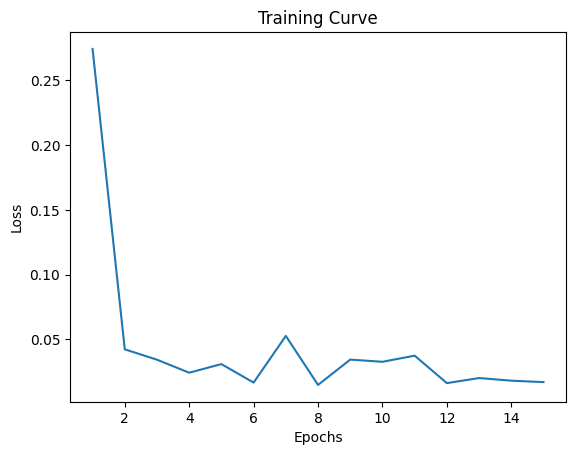

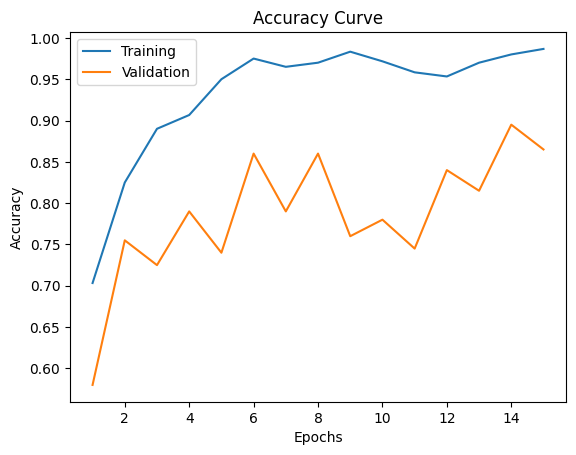

In [ ]:
resnet18 = models.resnet.resnet18(pretrained=True)
train_net(resnet18,train_loader, validation_loader, batch_size = 32, lr = 0.0001, num_epochs = 15)

Epoch 1/20
Training Accuracy: 0.6883, F1-Score: 0.7258, Loss: 1.7925
Validation Accuracy: 0.4200, F1-Score: 0.3310, Loss: 7.3948, 
Epoch 2/20
Training Accuracy: 0.8133, F1-Score: 0.8137, Loss: 0.6861
Validation Accuracy: 0.6250, F1-Score: 0.6209, Loss: 7.3668, 
Epoch 3/20
Training Accuracy: 0.8867, F1-Score: 0.8863, Loss: 0.3348
Validation Accuracy: 0.8100, F1-Score: 0.8024, Loss: 0.6118, 
Epoch 4/20
Training Accuracy: 0.9517, F1-Score: 0.9516, Loss: 0.1414
Validation Accuracy: 0.8400, F1-Score: 0.8397, Loss: 0.6403, 
Epoch 5/20
Training Accuracy: 0.9417, F1-Score: 0.9417, Loss: 0.1560
Validation Accuracy: 0.7350, F1-Score: 0.7405, Loss: 1.3466, 
Epoch 6/20
Training Accuracy: 0.9600, F1-Score: 0.9599, Loss: 0.1154
Validation Accuracy: 0.8150, F1-Score: 0.8137, Loss: 0.5736, 
Epoch 7/20
Training Accuracy: 0.9517, F1-Score: 0.9517, Loss: 0.1326
Validation Accuracy: 0.8200, F1-Score: 0.8155, Loss: 1.7141, 
Epoch 8/20
Training Accuracy: 0.9600, F1-Score: 0.9600, Loss: 0.1103
Validation Acc

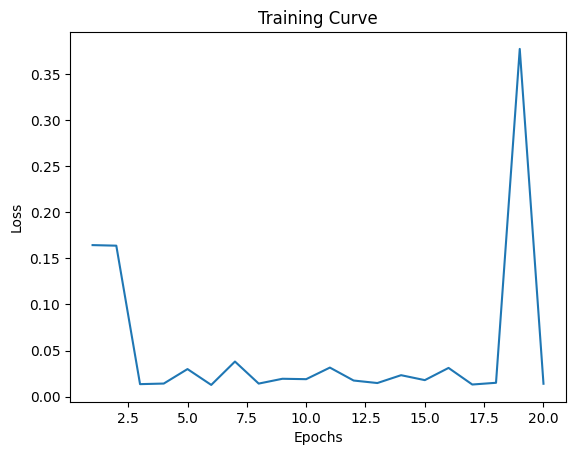

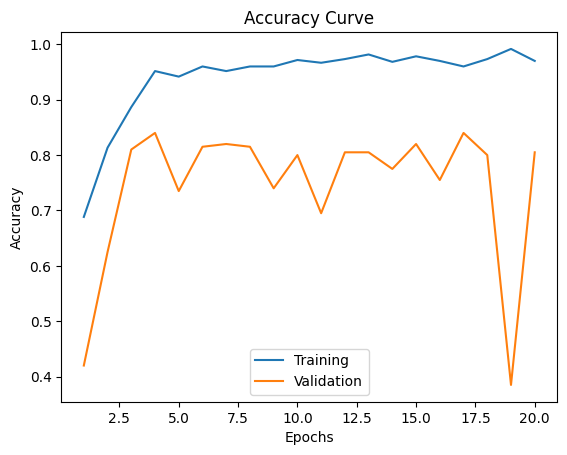

In [ ]:
train_net(resnet18,train_loader, validation_loader, batch_size = 45, lr = 0.001, num_epochs = 20)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20
Training Accuracy: 0.6633, F1-Score: 0.6983, Loss: 2.0701
Validation Accuracy: 0.4750, F1-Score: 0.4468, Loss: 3.5190, 
Epoch 2/20
Training Accuracy: 0.8267, F1-Score: 0.8268, Loss: 0.6973
Validation Accuracy: 0.7100, F1-Score: 0.7142, Loss: 1.4749, 
Epoch 3/20
Training Accuracy: 0.8717, F1-Score: 0.8715, Loss: 0.3464
Validation Accuracy: 0.8050, F1-Score: 0.8073, Loss: 0.6625, 
Epoch 4/20
Training Accuracy: 0.8967, F1-Score: 0.8966, Loss: 0.3413
Validation Accuracy: 0.6950, F1-Score: 0.6890, Loss: 2.1531, 
Epoch 5/20
Training Accuracy: 0.9333, F1-Score: 0.9333, Loss: 0.2043
Validation Accuracy: 0.8200, F1-Score: 0.8206, Loss: 0.8867, 
Epoch 6/20
Training Accuracy: 0.9517, F1-Score: 0.9516, Loss: 0.1303
Validation Accuracy: 0.8300, F1-Score: 0.8302, Loss: 0.7307, 
Epoch 7/20
Training Accuracy: 0.9617, F1-Score: 0.9616, Loss: 0.1270
Validation Accuracy: 0.8300, F1-Score: 0.8301, Loss: 0.7215, 
Epoch 8/20
Training Accuracy: 0.9550, F1-Score: 0.9550, Loss: 0.1327
Validation Acc

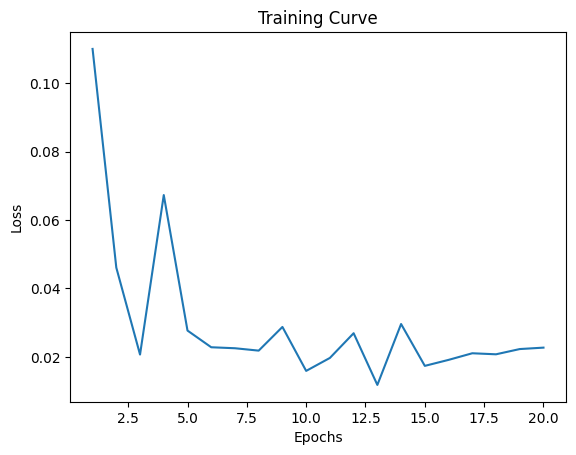

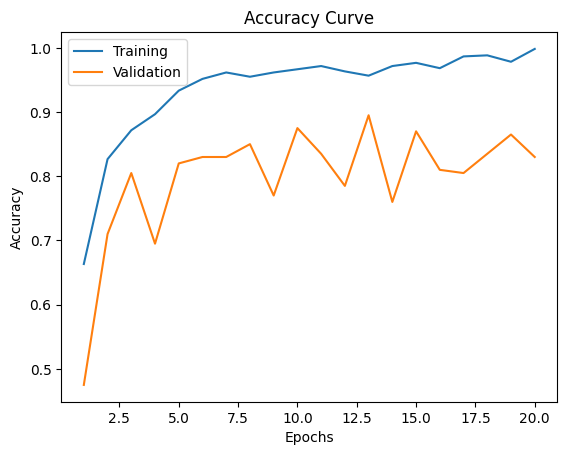

In [ ]:
resnet18 = models.resnet.resnet18(pretrained=True)
train_net(resnet18,train_loader, validation_loader, batch_size = 32, lr = 0.0001, num_epochs = 20)

In [ ]:
#Change the batchsize to see if it is helpful=  32--->45
torch.manual_seed(1)

#Data agumentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # resnet expects 224x224 inputs
    transforms.RandomHorizontalFlip(),  # Simple augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
])

# Load datasets:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
# Set up data loaders:
train_loader = DataLoader(train_dataset, batch_size=45, shuffle=True)  #Shuffle is to ensure the model isn’t adapting its learning to any kind of spurious pattern


# Define transformations and normalization for your images:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for the resnet model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for ImageNet
])

val_dataset = datasets.ImageFolder(val_dir, transform=transform)

# Set up data loaders:
validation_loader = DataLoader(val_dataset, batch_size=45, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15
Training Accuracy: 0.6433, F1-Score: 0.6895, Loss: 2.3944
Validation Accuracy: 0.4750, F1-Score: 0.3959, Loss: 29.4702, 
Epoch 2/15
Training Accuracy: 0.7400, F1-Score: 0.7390, Loss: 0.8211
Validation Accuracy: 0.4600, F1-Score: 0.4525, Loss: 3.1533, 
Epoch 3/15
Training Accuracy: 0.8133, F1-Score: 0.8136, Loss: 0.6074
Validation Accuracy: 0.8250, F1-Score: 0.8269, Loss: 0.5552, 
Epoch 4/15
Training Accuracy: 0.8100, F1-Score: 0.8101, Loss: 0.5406
Validation Accuracy: 0.7850, F1-Score: 0.7847, Loss: 0.6199, 
Epoch 5/15
Training Accuracy: 0.8300, F1-Score: 0.8293, Loss: 0.4323
Validation Accuracy: 0.7400, F1-Score: 0.7340, Loss: 0.8460, 
Epoch 6/15
Training Accuracy: 0.8050, F1-Score: 0.8048, Loss: 0.4774
Validation Accuracy: 0.7750, F1-Score: 0.7719, Loss: 0.7998, 
Epoch 7/15
Training Accuracy: 0.8717, F1-Score: 0.8696, Loss: 0.3259
Validation Accuracy: 0.7950, F1-Score: 0.7990, Loss: 0.5381, 
Epoch 8/15
Training Accuracy: 0.8583, F1-Score: 0.8590, Loss: 0.3693
Validation Ac

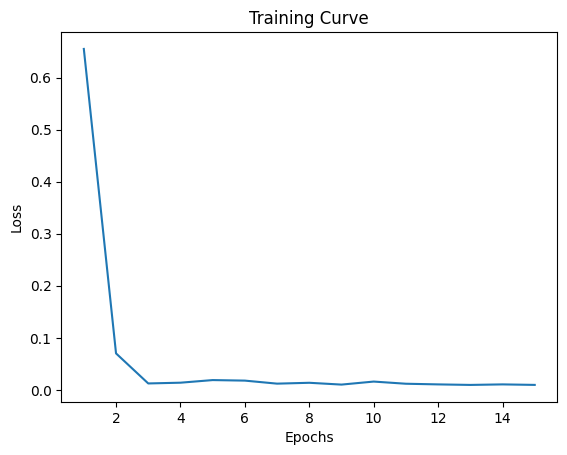

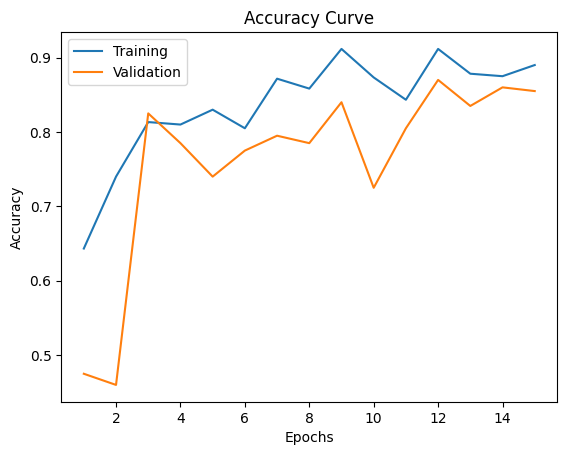

In [ ]:
resnet18 = models.resnet.resnet18(pretrained=True)
train_net(resnet18,train_loader, validation_loader, batch_size = 45, lr = 0.0001, num_epochs = 15)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30
Training Accuracy: 0.6433, F1-Score: 0.6893, Loss: 2.2267
Validation Accuracy: 0.4000, F1-Score: 0.2626, Loss: 59.6747, 
Epoch 2/30
Training Accuracy: 0.7500, F1-Score: 0.7500, Loss: 0.9283
Validation Accuracy: 0.6350, F1-Score: 0.5896, Loss: 3.6436, 
Epoch 3/30
Training Accuracy: 0.8017, F1-Score: 0.8043, Loss: 0.6185
Validation Accuracy: 0.7800, F1-Score: 0.7872, Loss: 0.6803, 
Epoch 4/30
Training Accuracy: 0.8033, F1-Score: 0.8016, Loss: 0.5587
Validation Accuracy: 0.8050, F1-Score: 0.8055, Loss: 0.5621, 
Epoch 5/30
Training Accuracy: 0.8283, F1-Score: 0.8302, Loss: 0.4929
Validation Accuracy: 0.8350, F1-Score: 0.8357, Loss: 0.4466, 
Epoch 6/30
Training Accuracy: 0.8600, F1-Score: 0.8579, Loss: 0.4112
Validation Accuracy: 0.7550, F1-Score: 0.7633, Loss: 0.7356, 
Epoch 7/30
Training Accuracy: 0.8917, F1-Score: 0.8925, Loss: 0.3060
Validation Accuracy: 0.8500, F1-Score: 0.8446, Loss: 0.5172, 
Epoch 8/30
Training Accuracy: 0.8617, F1-Score: 0.8615, Loss: 0.3751
Validation Ac

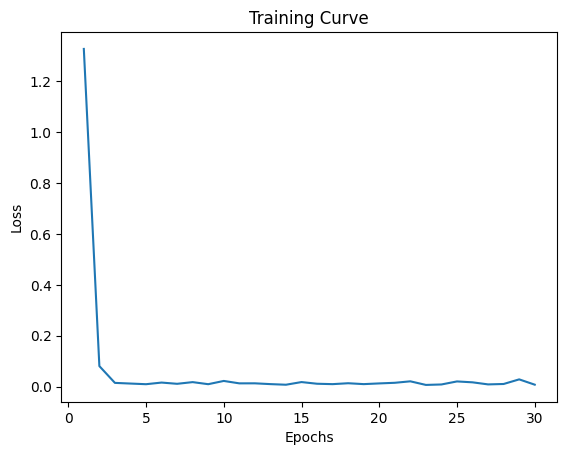

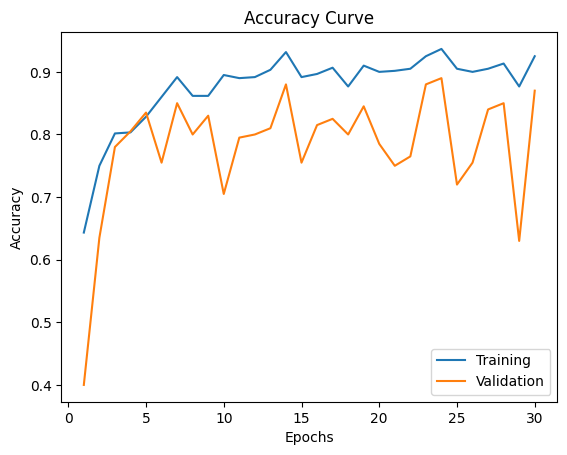

In [ ]:
resnet18 = models.resnet.resnet18(pretrained=True)
train_net(resnet18,train_loader, validation_loader, batch_size = 45, lr = 0.0001, num_epochs = 30)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15
Training Accuracy: 0.6483, F1-Score: 0.7016, Loss: 2.5303
Validation Accuracy: 0.2450, F1-Score: 0.1525, Loss: 11.9164, 
Epoch 2/15
Training Accuracy: 0.7683, F1-Score: 0.7697, Loss: 0.7489
Validation Accuracy: 0.5100, F1-Score: 0.4714, Loss: 1.3532, 
Epoch 3/15
Training Accuracy: 0.7833, F1-Score: 0.7807, Loss: 0.5347
Validation Accuracy: 0.7500, F1-Score: 0.7527, Loss: 0.9340, 
Epoch 4/15
Training Accuracy: 0.8083, F1-Score: 0.8049, Loss: 0.5849
Validation Accuracy: 0.7900, F1-Score: 0.7883, Loss: 0.6187, 
Epoch 5/15
Training Accuracy: 0.8250, F1-Score: 0.8246, Loss: 0.5121
Validation Accuracy: 0.5150, F1-Score: 0.4679, Loss: 2.3845, 
Epoch 6/15
Training Accuracy: 0.8300, F1-Score: 0.8304, Loss: 0.5135
Validation Accuracy: 0.7850, F1-Score: 0.7839, Loss: 0.6077, 
Epoch 7/15
Training Accuracy: 0.8433, F1-Score: 0.8421, Loss: 0.4069
Validation Accuracy: 0.7250, F1-Score: 0.7291, Loss: 0.8765, 
Epoch 8/15
Training Accuracy: 0.8717, F1-Score: 0.8720, Loss: 0.3220
Validation Ac

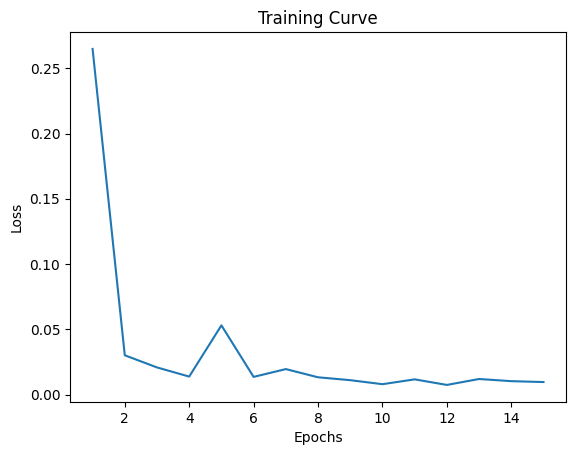

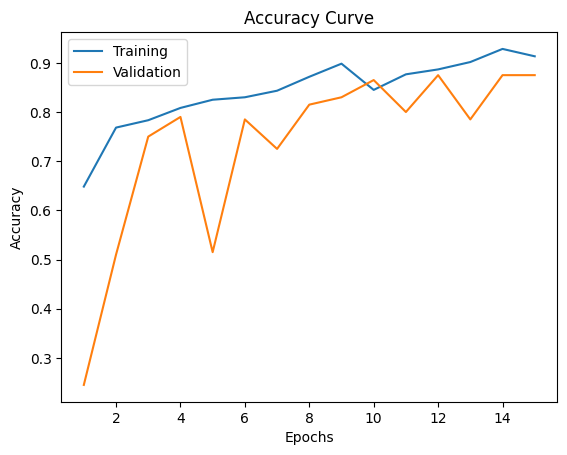

In [ ]:
resnet18 = models.resnet.resnet18(pretrained=True)
train_net(resnet18,train_loader, validation_loader, batch_size = 45, lr = 0.0001, num_epochs = 15)

#**Test**

In [ ]:
model = models.resnet.resnet18(pretrained=True)

for name, param in model.named_parameters() :
    param.requires_grad = False
    if name.startswith('classifier') :
        param.requires_grad = True

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
test_dir="/content/drive/MyDrive/Create Your Own Test Set"

In [ ]:
torch.manual_seed(1)
# Define transformations and normalization for your images:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for the VGG model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for ImageNet
])

test_dataset = datasets.ImageFolder(test_dir, transform=transform)
# Set up data loaders:
test_loader = DataLoader(test_dataset, batch_size=45, shuffle=False)

In [ ]:
def train_net(model, train_loader, test_loader, batch_size=32, lr=0.001, num_epochs=15):
    criterion = nn.CrossEntropyLoss()
    # For multi-class classification
    optimizer = optim.Adam(resnet18.parameters(), lr=0.001)  # Use Adam optimizer with a learning rate of 0.01

    n = 0
    iters, losses, train_acc_list,test_acc_list = [],[],[],[]
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        train_preds = []
        train_targets = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu")), labels.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = accuracy_score(train_targets, train_preds)
        train_acc_list.append(epoch_acc)
        epoch_f1 = f1_score(train_targets, train_preds, average='weighted')


        model.eval()  # Set model to evaluate mode
        test_running_loss = 0.0
        test_preds = []
        test_targets = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu")), labels.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                test_preds.extend(predicted.cpu().numpy())
                test_targets.extend(labels.cpu().numpy())

        test_loss = test_running_loss / len(test_loader.dataset)
        test_acc = accuracy_score(test_targets, test_preds)
        test_acc_list.append(test_acc)
        val_f1 = f1_score(test_targets, test_preds, average='weighted')

        n += 1
        iters.append(n)
        losses.append(float(test_loss)/batch_size)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Training Accuracy: {epoch_acc:.4f}, F1-Score: {epoch_f1:.4f}, Loss: {epoch_loss:.4f}')
        print(f'Test Accuracy: {test_acc:.4f}, F1-Score: {val_f1:.4f}, Loss: {test_loss:.4f}, ')
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy Curve")
    plt.plot(iters, train_acc_list, label="Training")
    plt.plot(iters, test_acc_list, label="Test")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1/15
Training Accuracy: 0.7483, F1-Score: 0.7505, Loss: 1.2648
Test Accuracy: 0.3200, F1-Score: 0.3130, Loss: 7.0369, 
Epoch 2/15
Training Accuracy: 0.8583, F1-Score: 0.8594, Loss: 0.4878
Test Accuracy: 0.6000, F1-Score: 0.6173, Loss: 2.1361, 
Epoch 3/15
Training Accuracy: 0.8967, F1-Score: 0.8968, Loss: 0.4018
Test Accuracy: 0.3950, F1-Score: 0.3673, Loss: 9.7592, 
Epoch 4/15
Training Accuracy: 0.8800, F1-Score: 0.8795, Loss: 0.4401
Test Accuracy: 0.5550, F1-Score: 0.5428, Loss: 4.3302, 
Epoch 5/15
Training Accuracy: 0.9033, F1-Score: 0.9034, Loss: 0.2578
Test Accuracy: 0.6900, F1-Score: 0.6815, Loss: 1.8316, 
Epoch 6/15
Training Accuracy: 0.9317, F1-Score: 0.9319, Loss: 0.2174
Test Accuracy: 0.6000, F1-Score: 0.6005, Loss: 2.4400, 
Epoch 7/15
Training Accuracy: 0.9383, F1-Score: 0.9383, Loss: 0.2054
Test Accuracy: 0.6250, F1-Score: 0.6305, Loss: 3.0907, 
Epoch 8/15
Training Accuracy: 0.9417, F1-Score: 0.9418, Loss: 0.1552
Test Accuracy: 0.6950, F1-Score: 0.6997, Loss: 1.4604, 


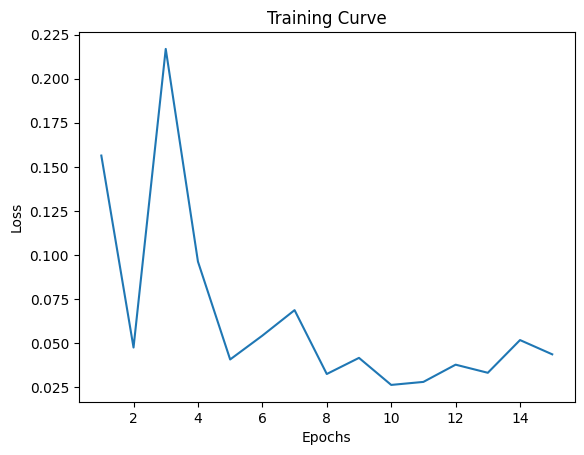

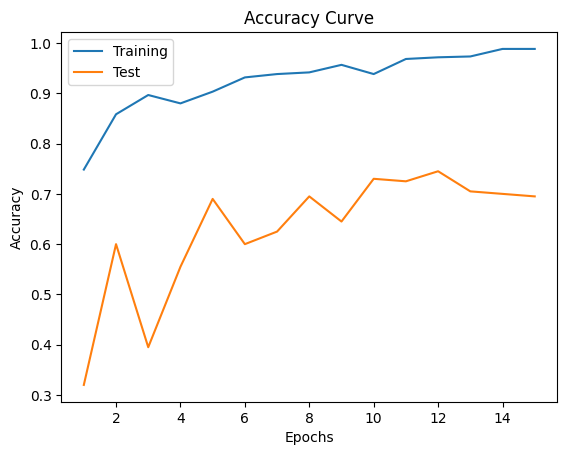

In [ ]:
train_net(resnet18,train_loader, test_loader, batch_size = 45, lr = 0.0001, num_epochs = 15)

In [ ]:
y_true = []
y_pred = []
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Then can move  model to the chosen device
resnet18.to(device)
resnet18.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Turn off gradients for test, saves memory and computations
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet18(inputs)

        # Convert outputs probabilities to predicted class (0 or 1) using argmax
        _, preds = torch.max(outputs, 1)

        # Move the results back to CPU and convert them to numpy arrays if not already
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

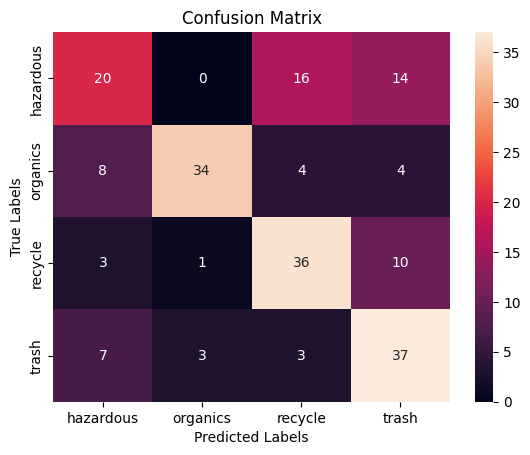

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `y_true` and `y_pred` are your true and predicted labels:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Labels')  # Set the label for the x-axis
plt.ylabel('True Labels')  # Set the label for the y-axis
# Set the tick labels on the x-axis and y-axis
plt.xticks(ticks=[0.5, 1.5, 2.5,3.5], labels=['hazardous', 'organics', 'recycle', 'trash'])
plt.yticks(ticks=[0.5, 1.5, 2.5,3.5], labels=['hazardous', 'organics', 'recycle', 'trash'])
plt.title('Confusion Matrix')
plt.show()